# Recursive Feature Elimination
RFE works by iteratively eliminating the least relevant features according to a model's performance, finally choosing the most informative subset.

![image](https://miro.medium.com/v2/resize:fit:3640/1*B3v-RJiDUduUptTmHiheUA.png)

## Process Overview
1. Train a model on the full set of features.
2. Fit the estimator, compute feature importances, drop the least important feature(s) (one at a time on small data sets).
3. Repeat the second step until you reach a given number of features

## Recursive Feature Elimination with Cross validation

Using CV to find optimal amount of features, instead of a manual selection

What RFECV does internally

1. Train a model on the full set of features.
2. Fit the estimator, compute feature importances, drop the least important feature(s).
3. For each number of features, run the above within CV, record the mean validation score.
4. Pick the number of features that gives the best mean CV score.
5. Refit the estimator on the entire training set, restricted to the selected features.

## Why should we use RFE?
RFE is especially helpful when:
- The dataset contains a large number of features.
- You suspect many features are redundant or irrelevant.
- You want to improve training speed and model generalization.

RFE can improve model performance by:
- Eliminating noisy or uninformative features.
- Reducing variance in predictions.
- Making models easier to interpret.

## Limitations
1. Computational Cost: It can be slow on very large datasets or when using complex models.
2. Dependency on the base model: Feature rankings depend heavily on the model used.
3. Risk of overfitting: If not cross-validated properly, it can overfit during feature selection.

# Example, Dataset "Wine"

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import RFE, RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [23]:
# Load data
wine = load_wine()
X, y = wine.data, wine.target
feature_names = wine.feature_names
target_names = wine.target_names

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Show first 5 samples and 8 out of 13 features as a table
df_preview = pd.DataFrame(X[:, :8], columns=feature_names[:8])
df_preview["target"] = [target_names[i] for i in y]
print(df_preview.head().to_string(index=False))

 alcohol  malic_acid  ash  alcalinity_of_ash  magnesium  total_phenols  flavanoids  nonflavanoid_phenols  target
   14.23        1.71 2.43               15.6      127.0           2.80        3.06                  0.28 class_0
   13.20        1.78 2.14               11.2      100.0           2.65        2.76                  0.26 class_0
   13.16        2.36 2.67               18.6      101.0           2.80        3.24                  0.30 class_0
   14.37        1.95 2.50               16.8      113.0           3.85        3.49                  0.24 class_0
   13.24        2.59 2.87               21.0      118.0           2.80        2.69                  0.39 class_0


# Example, RFE + DecisionTree, Have to specify number of features to keep

In [27]:
# Simple RFE (no CV)
tree = DecisionTreeClassifier(random_state=42)
rfe = RFE(estimator=tree, n_features_to_select=5) #RFE: Have to set number of features to keep, removing one feature each step (default)
rfe.fit(X_train, y_train)

selected_1 = [f for f, keep in zip(feature_names, rfe.support_) if keep] #"rfe.support_:" is a boolean mask marking which features were kept

tree.fit(X_train[:, rfe.support_], y_train) #Trains a fresh Decision Tree on the reduced feature set (only the selected columns of X_train).
y_pred_1 = tree.predict(X_test[:, rfe.support_]) #Predict on the test set, only using chosen features

print(f"Selected features: {selected_1}")
print(f"Test accuracy: {accuracy_score(y_test, y_pred_1):.4f}")

Selected features: ['ash', 'flavanoids', 'color_intensity', 'od280/od315_of_diluted_wines', 'proline']
Test accuracy: 0.9722


# Example, RFECV + DecisionTree

Optimal features: 3
Selected features: ['flavanoids', 'color_intensity', 'proline']
Test accuracy: 0.9444


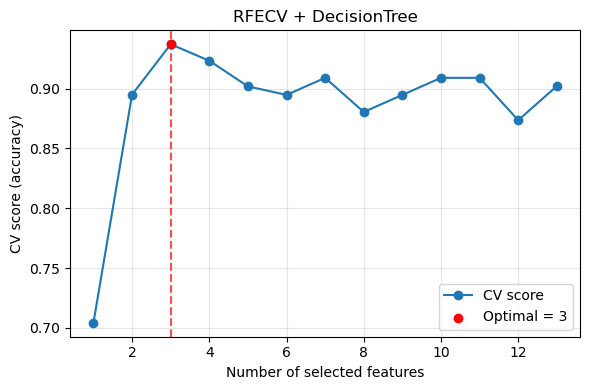

In [28]:
# RFECV + Decisiontree
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) #Stratified: preserves class proportions in each fold
rfecv_tree = RFECV(estimator=DecisionTreeClassifier(random_state=42), cv=cv, scoring="accuracy", step=1, n_jobs=-1) #Step=1, remove one feature each loop
rfecv_tree.fit(X_train, y_train)

selected_2 = [f for f, keep in zip(feature_names, rfecv_tree.support_) if keep] # rfecv_tree.support_: boolean mask of selected features.
y_pred_2 = rfecv_tree.predict(X_test) #RFECV.predict automatically applies the feature mask internally (so you don’t need to slice X_test manually).

print(f"Optimal features: {rfecv_tree.n_features_}") # rfecv_tree.n_features_: the optimal number chosen via CV.
print(f"Selected features: {selected_2}")
print(f"Test accuracy: {accuracy_score(y_test, y_pred_2):.4f}")

# Plot CV score vs number of features with optimal indicator
scores2 = rfecv_tree.cv_results_["mean_test_score"] # rfecv_tree.cv_results_["mean_test_score"]: CV score per number of features tried.
xs2 = np.arange(1, len(scores2) + 1)
best_x2 = rfecv_tree.n_features_
best_y2 = scores2[best_x2 - 1]
plt.figure(figsize=(6, 4))
plt.plot(xs2, scores2, marker="o", label="CV score")
plt.scatter([best_x2], [best_y2], color="red", zorder=5, label=f"Optimal = {best_x2}")
plt.axvline(best_x2, color="red", linestyle="--", alpha=0.7)
plt.xlabel("Number of selected features")
plt.ylabel("CV score (accuracy)")
plt.title("RFECV + DecisionTree")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Example, RFECV, LogisticRegression + Scaling

Optimal features: 8
Selected features: ['alcohol', 'ash', 'alcalinity_of_ash', 'flavanoids', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
Test accuracy: 1.0000


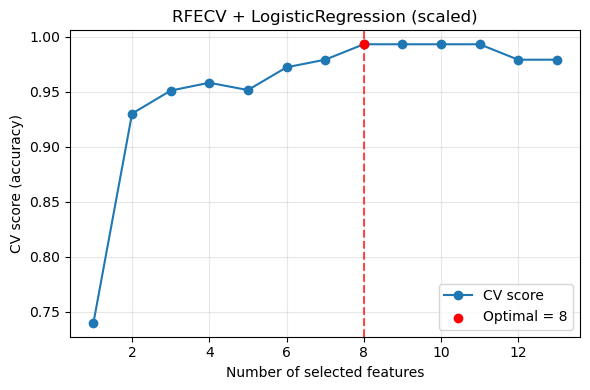

In [30]:
# RFECV + LogisticRegression
rfecv_logreg = RFECV(estimator=LogisticRegression(max_iter=1000, random_state=42), cv=cv, scoring="accuracy", step=1, n_jobs=-1)

pipe = Pipeline([("scale", StandardScaler()), ("rfecv", rfecv_logreg)])
pipe.fit(X_train, y_train)
mask_3 = pipe.named_steps["rfecv"].support_
selected_3 = [f for f, keep in zip(feature_names, mask_3) if keep]
y_pred_3 = pipe.predict(X_test)

print(f"Optimal features: {pipe.named_steps['rfecv'].n_features_}")
print(f"Selected features: {selected_3}")
print(f"Test accuracy: {accuracy_score(y_test, y_pred_3):.4f}")

# Plot CV score with optimal indicator for LogisticRegression
scores3 = pipe.named_steps["rfecv"].cv_results_["mean_test_score"]
xs3 = np.arange(1, len(scores3) + 1)
best_x3 = pipe.named_steps["rfecv"].n_features_
best_y3 = scores3[best_x3 - 1]
plt.figure(figsize=(6, 4))
plt.plot(xs3, scores3, marker="o", label="CV score")
plt.scatter([best_x3], [best_y3], color="red", zorder=5, label=f"Optimal = {best_x3}")
plt.axvline(best_x3, color="red", linestyle="--", alpha=0.7)
plt.xlabel("Number of selected features")
plt.ylabel("CV score (accuracy)")
plt.title("RFECV + LogisticRegression (scaled)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Optimal features: 8
Selected features: ['alcohol', 'ash', 'alcalinity_of_ash', 'flavanoids', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
Test accuracy: 1.0000


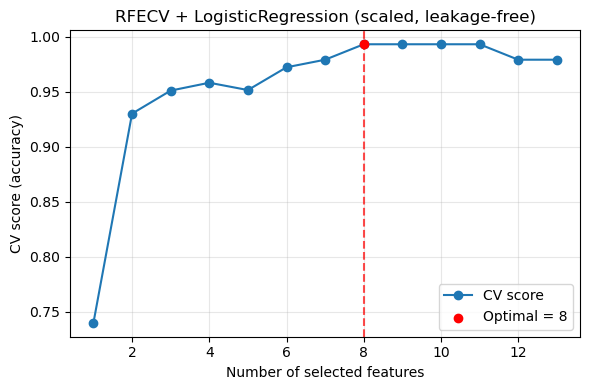

In [32]:
# RFECV estimator: scale inside each CV fold, then LogisticRegression
rfecv_logreg = RFECV(
    estimator=Pipeline([
        ("scale", StandardScaler()),
        ("logreg", LogisticRegression(max_iter=1000, random_state=42, solver="lbfgs"))
    ]),
    cv=cv,                           # your StratifiedKFold splitter
    scoring="accuracy",
    step=1,
    n_jobs=-1,
    importance_getter="named_steps.logreg.coef_"  # <-- key fix
)

# Outer pipeline contains only RFECV
pipe = Pipeline([("rfecv", rfecv_logreg)])
pipe.fit(X_train, y_train)

# Selected features (boolean mask) and human-readable names
mask_3 = pipe.named_steps["rfecv"].support_
selected_3 = [f for f, keep in zip(feature_names, mask_3) if keep]

# Predict on the held-out TEST set (pipeline applies scaling + mask internally)
y_pred_3 = pipe.predict(X_test)

print(f"Optimal features: {pipe.named_steps['rfecv'].n_features_}")
print(f"Selected features: {selected_3}")
print(f"Test accuracy: {accuracy_score(y_test, y_pred_3):.4f}")

# Plot
scores3 = pipe.named_steps["rfecv"].cv_results_["mean_test_score"]
xs3 = np.arange(1, len(scores3) + 1)
best_x3 = pipe.named_steps["rfecv"].n_features_
best_y3 = scores3[best_x3 - 1]

plt.figure(figsize=(6, 4))
plt.plot(xs3, scores3, marker="o", label="CV score")
plt.scatter([best_x3], [best_y3], color="red", zorder=5, label=f"Optimal = {best_x3}")
plt.axvline(best_x3, color="red", linestyle="--", alpha=0.7)
plt.xlabel("Number of selected features")
plt.ylabel("CV score (accuracy)")
plt.title("RFECV + LogisticRegression (scaled, leakage-free)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Sources

- https://www.geeksforgeeks.org/machine-learning/recursive-feature-elimination/
- https://www.scikit-yb.org/en/latest/api/model_selection/rfecv.html